Setup and Data Loading

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data.csv', header=None, names=['x1', 'x2', 'label'])
X = data[['x1', 'x2']].values
y = data['label'].values

# Set random seed for consistent weight initialization
np.random.seed(42)

 Helper Function: Plot Decision Boundary

In [ ]:
# Helper function to visualize boundaries
def plot_decision_boundary(X, y, W, b, iteration_info, lr, title_prefix, color='black', linestyle='-', show_legend=False):
    """Plots data points and the decision boundary W.X + b = 0."""
    if iteration_info == 'Initial' or show_legend: # Plot data points on first or last call for a figure
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0' if show_legend else "", alpha=0.7)
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1' if show_legend else "", alpha=0.7)

    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x_vals = np.array([x1_min, x1_max])

 
    if abs(W[1]) > 1e-6:
        x2_vals = (-W[0] * x_vals - b) / W[1]
        plt.plot(x_vals, x2_vals, color=color, linestyle=linestyle, alpha=0.3 if linestyle=='--' else 1.0)
    elif abs(W[0]) > 1e-6:
        x1_vert = -b / W[0]
        x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        plt.plot([x1_vert, x1_vert], [x2_min, x2_max], color=color, linestyle=linestyle, alpha=0.3 if linestyle=='--' else 1.0)

    if show_legend:
        plt.title(f'{title_prefix} (LR={lr}, Status: {iteration_info})')
        plt.xlabel('Feature x1'); plt.ylabel('Feature x2')
        plt.xlim(x1_min, x1_max); plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
        plt.legend(); plt.grid(True); plt.show()

Heuristic Perceptron Implementation

Algorithm: Implemented the heuristic Perceptron algorithm as described in the assignment instructions ("left box" on PDF page 2).   
Classification: Point classification was performed using a step function: a point X was assigned to class 1 if W⋅X+b≥0, and class 0 otherwise.
Update Rule: Weights (W) and bias (b) were updated only when a point was misclassified, strictly following the rules:
If predicted class = 0 (false negative, true label=1): W←W+rX, b←b+r.
If predicted class = 1 (false positive, true label=0): W←W−rX, b←b−r.
  
Iteration: The process iterated through the dataset repeatedly until either no misclassifications occurred in a full pass (convergence) or a maximum iteration limit was reached.
Visualization: The initial boundary was plotted in red, updates triggered intermediate dashed green lines (plotted periodically), and the final boundary upon completion was plotted in black. Experiments were run for learning rates [0.01, 0.1, 1.0]


-- Different learning rates ---
Part 1 Result (LR=0.01): Stopped at 1000 iters. Total Updates: 5411


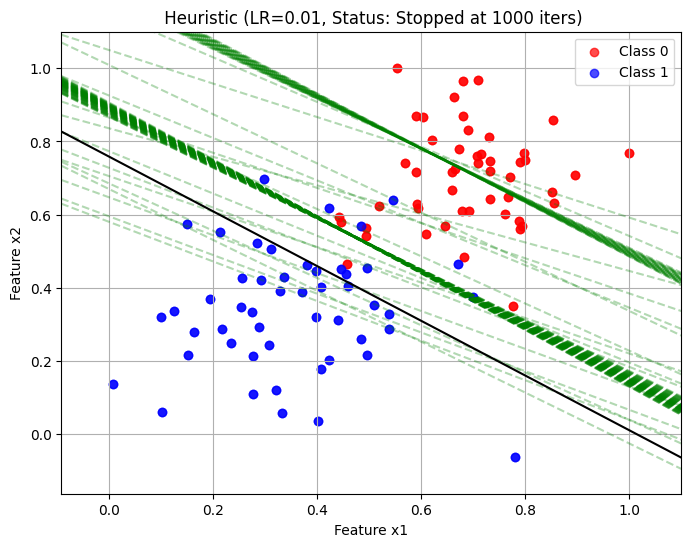

Part 1 Result (LR=0.1): Stopped at 200 iters. Total Updates: 940


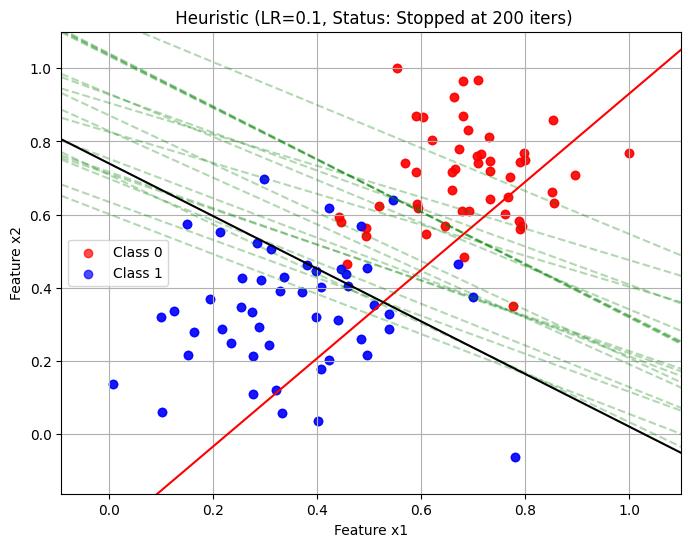

Part 1 Result (LR=1.0): Stopped at 200 iters. Total Updates: 944


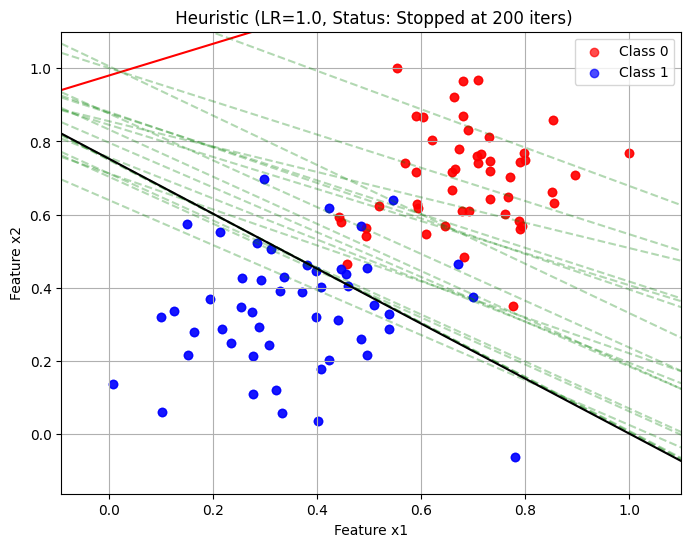

In [ ]:
def run_part1_heuristic(X, y, learning_rate, max_iterations):
    """Implements Part 1 Heuristic Perceptron based on specific PDF rules."""
    n_samples, n_features = X.shape
    W = np.random.rand(n_features) * 0.02 - 0.01 # Initialize weights
    b = np.random.rand() * 0.02 - 0.01         # Initialize bias

    plt.figure(figsize=(8, 6))
    plot_decision_boundary(X, y, W, b, 'Initial', learning_rate, "Part 1: Heuristic", color='red', linestyle='-')

    converged = False
    updates_made = 0
    for iteration in range(max_iterations):
        misclassified_in_epoch = 0
        for idx, xi in enumerate(X):
            yi = y[idx]
            linear_output = np.dot(xi, W) + b
            predicted_class = 1 if linear_output >= 0 else 0 # Step function classification

            if predicted_class != yi: # Update only if misclassified
                misclassified_in_epoch += 1
                updates_made += 1
                # Apply specific update rules 
                if predicted_class == 0: # Predicted 0, must be 1 -> Increase score
                    b += learning_rate
                    W += learning_rate * xi
                elif predicted_class == 1: # Predicted 1, must be 0 -> Decrease score
                    b -= learning_rate
                    W -= learning_rate * xi

                # Plot intermediate boundary occasionally
                if updates_made % (n_samples // 2) == 0: 
                     plot_decision_boundary(X, y, W, b, f'Update {updates_made}', learning_rate, "Part 1: Heuristic", color='green', linestyle='--')

        if misclassified_in_epoch == 0: 
            converged = True
            break

    final_iterations_info = f"Converged in {iteration + 1} iters" if converged else f"Stopped at {max_iterations} iters"
    print(f"Part 1 Result (LR={learning_rate}): {final_iterations_info}. Total Updates: {updates_made}")
    plot_decision_boundary(X, y, W, b, final_iterations_info, learning_rate, " Heuristic", color='black', linestyle='-', show_legend=True) # Final plot

    # --- Experiment with Learning Rates ---
learning_rates_part1 = [0.01, 0.1, 1.0]
max_iterations_part1 = {0.01: 1000, 0.1: 200, 1.0: 200} 

print("\n-- Different learning rates ---")
for lr in learning_rates_part1:
    max_iter = max_iterations_part1[lr]
    run_part1_heuristic(X, y, lr, max_iter)


Part 2 aimed to implement the Perceptron using a Gradient Descent approach with a Sigmoid activation function 
 . The goal was to analyze the effect of the learning rate (r) over a fixed number of epochs (100) and evaluate convergence using the Log Loss (Binary Cross-Entropy) error metric.


The algorithm was implemented using the Sigmoid activation and the Gradient Descent update rules (W←W+r(y−σ(z))X, b←b+r(y−σ(z))) as specified. Experiments were run for 100 epochs with learning rates r=0.01, r=0.1, and r=1.0.

In [ ]:
# Activation function
def sigmoid(z):
    z = np.clip(z, -50, 50) # Prevent overflow/underflow
    return 1.0 / (1.0 + np.exp(-z))

# Loss function
def calculate_log_loss(y_true, y_pred_proba):
    epsilon = 1e-15 
    y_pred_clipped = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = - (y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    return np.mean(loss)


--- Learning rates ---
Part 2 Result (LR=0.01): Finished 100 epochs. Final LogLoss: 0.3221


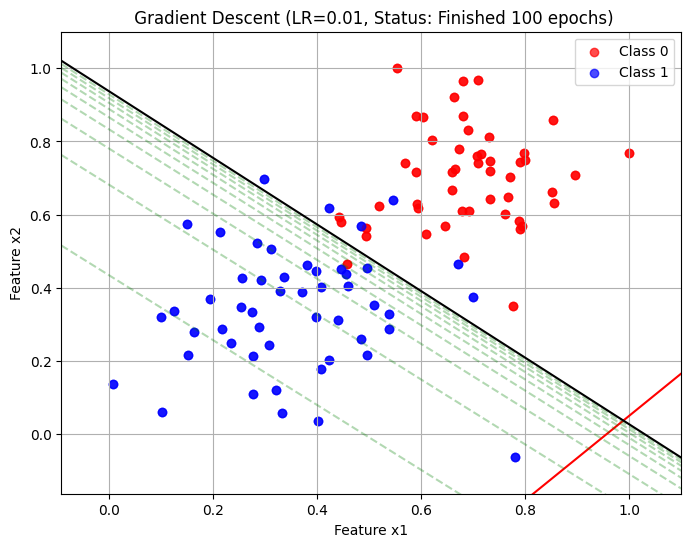

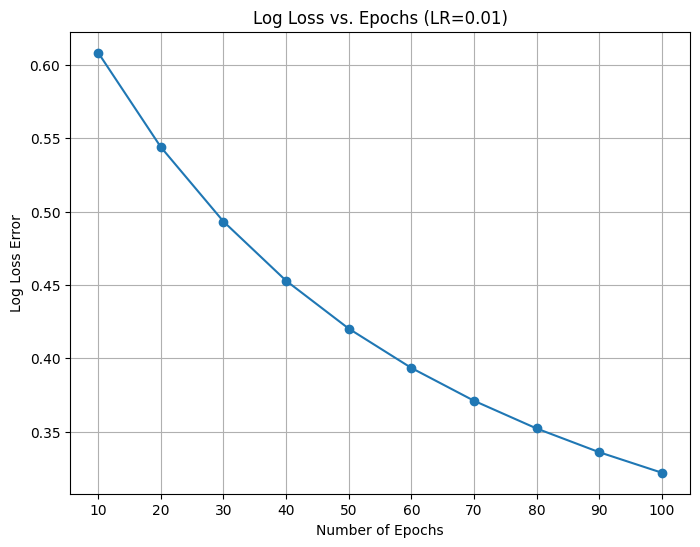

Part 2 Result (LR=0.1): Finished 100 epochs. Final LogLoss: 0.1565


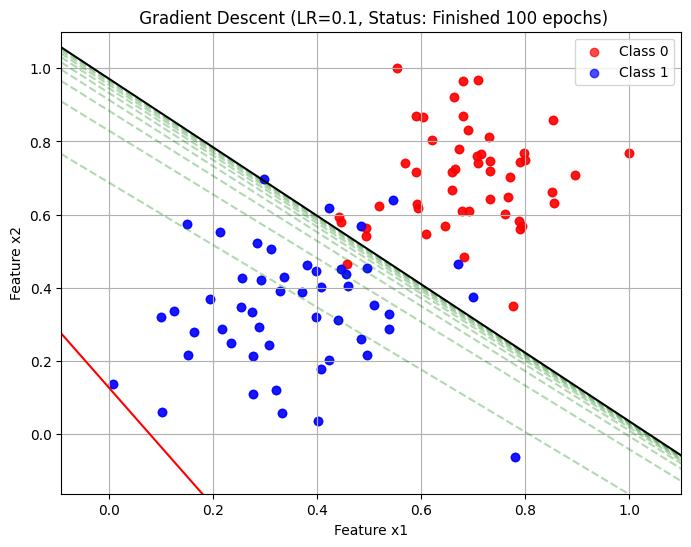

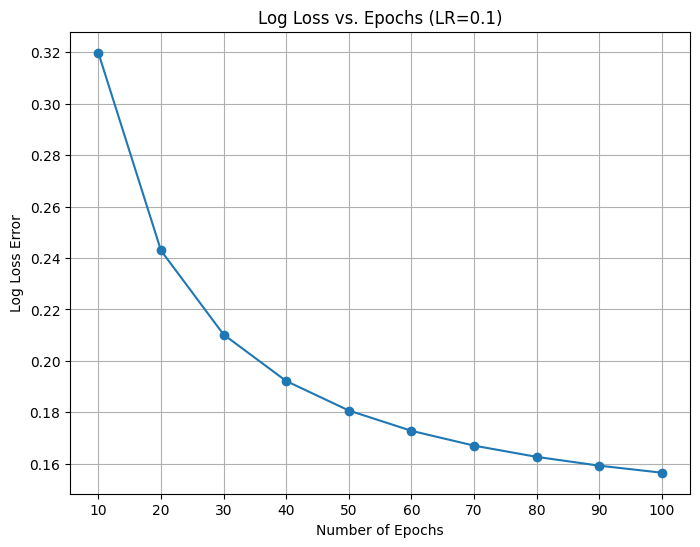

Part 2 Result (LR=1.0): Finished 100 epochs. Final LogLoss: 0.1227


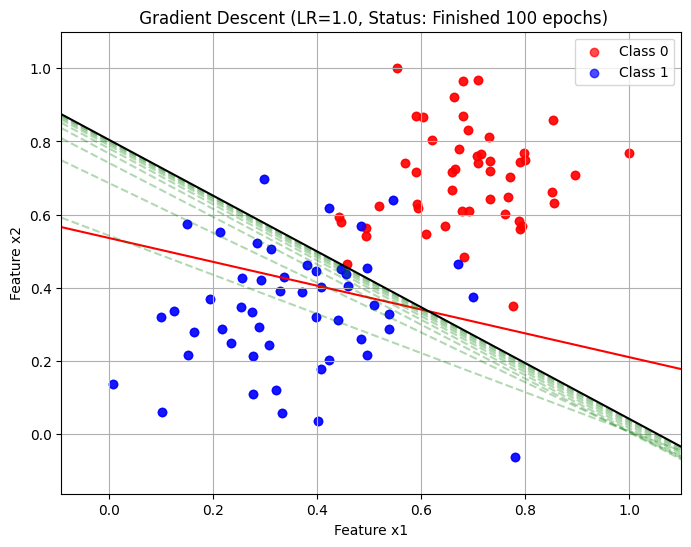

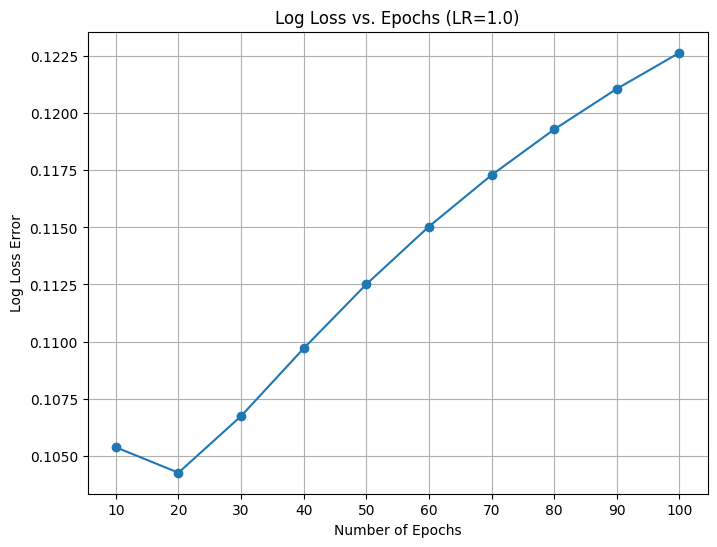

In [ ]:
def run_part2_gradient_descent(X, y, learning_rate, epochs):
    """ Gradient Descent with Sigmoid."""
    n_samples, n_features = X.shape
    W = np.random.rand(n_features) * 0.02 - 0.01 # Initialize weights
    b = np.random.rand() * 0.02 - 0.01         # Initialize bias

    log_loss_history = []
    epoch_numbers_for_plot = []

    plt.figure(figsize=(8, 6)) 
    plot_decision_boundary(X, y, W, b, 'Initial', learning_rate, " Gradient Descent", color='red', linestyle='-')

    for epoch in range(epochs):
        y_preds_epoch = np.zeros(n_samples)
        for idx, xi in enumerate(X):
            yi = y[idx]
            z = np.dot(xi, W) + b
            y_hat = sigmoid(z) # Use sigmoid activation
            y_preds_epoch[idx] = y_hat
            error = yi - y_hat # Error based on sigmoid output

            # Apply Gradient Descent update rules [cite: 7]
            b += learning_rate * error
            W += learning_rate * error * xi

        # Plot intermediate boundary every 10 epochs
        if (epoch + 1) % 10 == 0 and epoch < epochs - 1:
            plot_decision_boundary(X, y, W, b, f'Epoch {epoch+1}', learning_rate, " Gradient Descent", color='green', linestyle='--')

        # Compute and store log loss every 10 epochs [cite: 2]
        if (epoch + 1) % 10 == 0:
            current_loss = calculate_log_loss(y, y_preds_epoch)
            log_loss_history.append(current_loss)
            epoch_numbers_for_plot.append(epoch + 1)

    final_epoch_info = f"Finished {epochs} epochs"
    print(f"Part 2 Result (LR={learning_rate}): {final_epoch_info}. Final LogLoss: {log_loss_history[-1]:.4f}")
    plot_decision_boundary(X, y, W, b, final_epoch_info, learning_rate, " Gradient Descent", color='black', linestyle='-', show_legend=True) # Final boundary plot

    # Plot Log Loss Error history
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_numbers_for_plot, log_loss_history, marker='o')
    plt.title(f'Log Loss vs. Epochs (LR={learning_rate})'); plt.xlabel('Number of Epochs'); plt.ylabel('Log Loss Error')
    plt.xticks(epoch_numbers_for_plot); plt.grid(True); plt.show()

    learning_rates_part2 = [0.01, 0.1, 1.0]
epochs_part2 = 100

print("\n--- Learning rates ---")
for lr in learning_rates_part2:
    run_part2_gradient_descent(X, y, lr, epochs_part2)